# 2 qubit GST for XYICZ gate set with identity implemented as waiting time

In [2]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [3]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt
#from pygsti.modelpacks import smq2Q_XYICNOT as std

%run ../src/mGST/reporting.py

### Setting the parameters

In [4]:
pdim = 4   # physical dimension
r = pdim**2   # rank of the gate superoperators 

max_l = 10  # maximum number of gates in each measurement sequence
n_povm = 4   # number of POVM-elements
d = 6

In [5]:
from true_values import E_true, X_true, rho_true
X_t = X_true[:d].copy()
E_t = E_true.copy()
rho_t = rho_true.copy()
target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #Save new model with CZ instead of CNOT

### Loading data

In [6]:
# Hardware probabilities
filename = 'data/20230504-1345_cgst_500_5_7_10/20230504-1345_cgst'

with open(filename + '_depth_5.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J5 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
y5 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open(filename + '_depth_7.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J7 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
y7 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

with open(filename + '_depth_10.json') as f:
    data = json.load(f)
N = data['nsequences']
l = data['depth']
J10 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
y10 = np.array([[data['measurements'][i]['hardware_probabilities'][basis_str] for i in range(N)] for basis_str in ['00','01','10','11']])

J57 = np.concatenate((J5,J7), axis = 0)
y57 = np.concatenate((y5,y7), axis = 1)

J_all = np.concatenate((J57,J10), axis = 0)
y_all = np.concatenate((y57,y10), axis = 1)

meas_samples = data['nshots']

In [6]:
# #Simulation probabilities
# basis_str_dict = {'00':0, '01':1, '10':2, '11':3}
# filename = 'data/20230504-1345_cgst_500_5_7_10/20230504-1345_cgst'

# with open(filename + '_depth_5.json') as f:
#     data = json.load(f)
# N = data['nsequences']
# l = data['depth']
# J5 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
# y5 = np.zeros((n_povm,N))
# for i in range(N):
#     keylist = [key for key in data['measurements'][i]['simulation_probabilities'].keys()]
#     for key in data['measurements'][i]['simulation_probabilities'].keys():
#         y5[basis_str_dict[key],i] = data['measurements'][i]['simulation_probabilities'][key]

# with open(filename + '_depth_7.json') as f:
#     data = json.load(f)
# N = data['nsequences']
# l = data['depth']
# J7 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
# y7 = np.zeros((n_povm,N))
# for i in range(N):
#     keylist = [key for key in data['measurements'][i]['simulation_probabilities'].keys()]
#     for key in data['measurements'][i]['simulation_probabilities'].keys():
#         y7[basis_str_dict[key],i] = data['measurements'][i]['simulation_probabilities'][key]

# with open(filename + '_depth_10.json') as f:
#     data = json.load(f)
# N = data['nsequences']
# l = data['depth']
# J10 = np.array([list(np.pad(data['measurements'][i]['circuit'],(0,max_l-l),'constant',constant_values=-1)) for i in range(N)])[:,::-1]
# y10 = np.zeros((n_povm,N))
# for i in range(N):
#     for key in data['measurements'][i]['simulation_probabilities'].keys():
#         y10[basis_str_dict[key],i] = data['measurements'][i]['simulation_probabilities'][key]

# J57 = np.concatenate((J5,J7), axis = 0)
# y57 = np.concatenate((y5,y7), axis = 1)

# J_all = np.concatenate((J57,J10), axis = 0)
# y_all = np.concatenate((y57,y10), axis = 1)

# meas_samples = data['nshots']

### GST

In [ ]:
bsize = 120   # The batch size on which the optimization is started
results = []
rK = 2
for _ in range(20):  
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    K,X,E,rho,res_list = algorithm.run_mGST(y_all, J_all, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 1, max_iter = 150, final_iter = 70, threshold_multiplier = 5, 
                         target_rel_prec = 1e-5, testing = True)   
    # K,X,E,rho,res_list = algorithm.run_mGST(y_all,J_all, max_l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
    #                      max_inits = 10, max_iter = 0, final_iter = 30, threshold_multiplier = 500, 
    #                      target_rel_prec = 1e-4, init = [K,E,rho], testing = True)   
    results.append([K,X,E,rho])

In [17]:
# ###################################### 
# filename = 'rank_2_hardware_probs_1345_G0'
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[4],'phys. dimension':int(np.sqrt(r)), 'Sequence count': N, 
#               'J':J_all,'y':y_all, 'target_rel_prec':1e-5}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis

## Rank 1

In [7]:
with open('rank_1_hardware_probs_1345', 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [9]:
for i in range(1):
    K,X,E,rho = results[i][:]
    weights = {'G0': 1,'G1':1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
    gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

    X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
    df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J57, y57, target_mdl, gate_labels)

    display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,99530","0,10296","0,08449"
Rx(pi/2)[q0],"0,99915","0,04358","0,03397"
Ry(pi/2)[q0],"0,99746","0,07435","0,05480"
Rx(pi/2)[q1],"0,99206","0,11310","0,09862"
Ry(pi/2)[q1],"0,99042","0,12375","0,11331"
CZ[q0-q1],"0,22793","1,00000","0,62103"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.002502,0.055060,0.206069,0.209391,0.096097


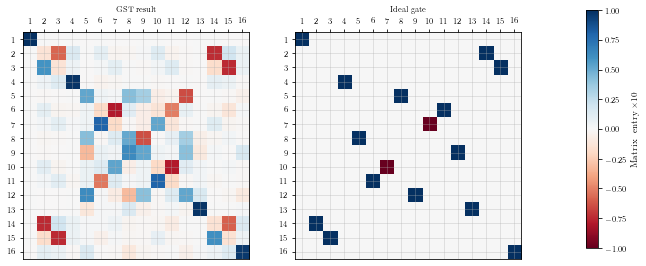

In [10]:
X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt, E_opt, rho_opt)
X_t_pp, E_t_pp, rho_t_pp = compatibility.std2pp(X_t, E_t, rho_t)
plot_mat(X_opt_pp[5], X_t_pp[5])

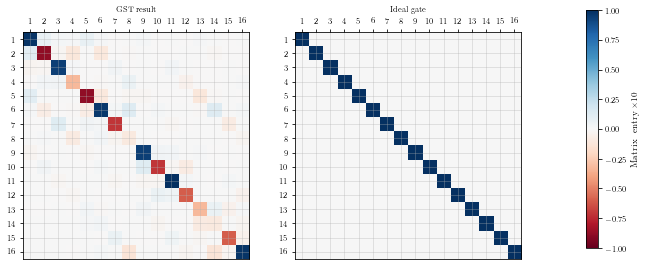

In [11]:
plot_mat(X_opt[5]@X_t[5].T.conj(), X_t[5]@X_t[5].T.conj())

Assignment fidelity for ideal basis state 0: 0.48080726618874287


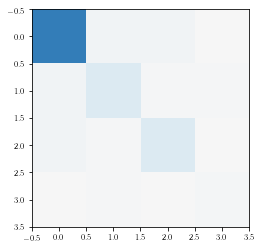

Assignment fidelity for ideal basis state 1: 0.6866474693441048


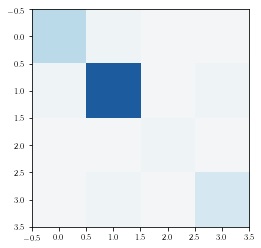

Assignment fidelity for ideal basis state 2: 0.38880994628571747


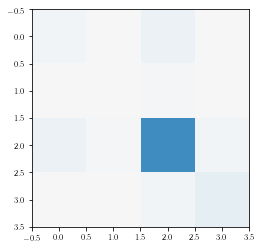

Assignment fidelity for ideal basis state 3: 0.517394067824914


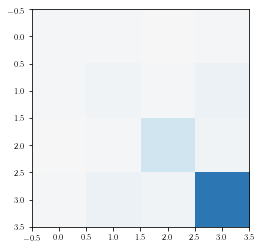

In [13]:
for i in range(4):
    print("Assignment fidelity for ideal basis state %i:"%i, np.abs(E_opt.reshape(4,4,4)[i,i,i])**2)
    plt.imshow(np.abs(E_opt.reshape(4,4,4)[i,:,:]), vmin = -1, vmax = 1)
    plt.show()

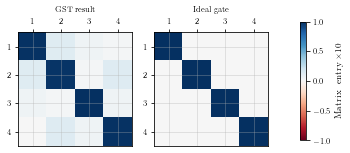

In [14]:
K_t = additional_fns.Kraus_rep(X_t,d,pdim,1)
K_opt = additional_fns.Kraus_rep(X_opt,d,pdim,1)
plot_mat(np.abs(K_opt[5][0]), np.abs((K_t[5][0])))

0.0
2.705277328075611
0.3185002878764526
1.231734166826501


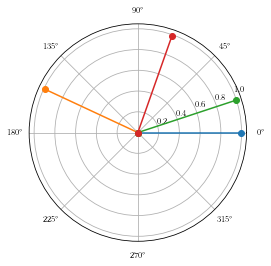

In [15]:
for x in np.diag(K_opt[5][0]):
    print(np.angle(x))
    plt.polar([0,np.angle(x)],[0,abs(x)],marker='o')
plt.show()

### Rank 2

In [16]:
with open("rank_2_hardware_probs_1345", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [17]:
K,X,E,rho = results[0][:]

weights = {'G0': 1,'G1': 1, 'G2': 1, 'G3': 1, 'G4': 1, 'G5': 1, 'spam': 1}
gate_labels = {0: "Id", 1: "Rx(pi/2)[q0]", 2: "Ry(pi/2)[q0]", 3: "Rx(pi/2)[q1]", 4: "Ry(pi/2)[q1]", 5: "CZ[q0-q1]"}

X_opt, E_opt, rho_opt = gauge_opt(X, E, rho, target_mdl, weights)
df_g, df_o, s_g, s_o = report(X_opt, E_opt, rho_opt, J_all, y_all, target_mdl, gate_labels)

display(s_g), display(s_o)

,F_avg,Diamond distances,Min. Spectral distances
Id,"0,98245","0,11156","0,08941"
Rx(pi/2)[q0],"0,98022","0,09078","0,05312"
Ry(pi/2)[q0],"0,98675","0,10286","0,05967"
Rx(pi/2)[q1],"0,96472","0,13495","0,11279"
Ry(pi/2)[q1],"0,97450","0,15695","0,12496"
CZ[q0-q1],"0,29035","0,99495","0,69380"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.002246,0.054919,0.224980,0.143983,0.075130


(None, None)

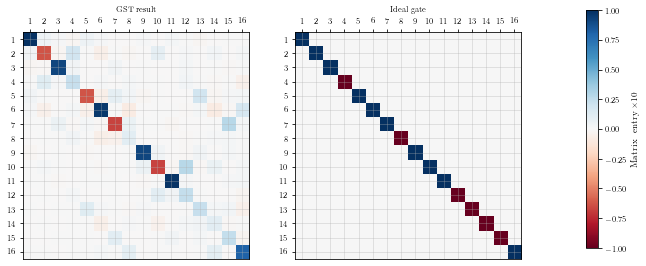

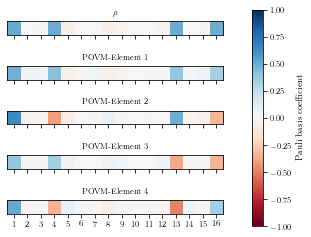

In [18]:
gate_index = 5

X_opt_pp, E_opt_pp, rho_opt_pp = compatibility.std2pp(X_opt,E_opt,rho_opt)
X_t_pp, E_t_pp, rho_t_pp = compatibility.pygsti_model_to_arrays(target_mdl,basis = 'pp')


plot_mat(X_opt[gate_index], X_t[gate_index])
plot_spam(rho_opt_pp, E_opt_pp)

Assignment fidelity for ideal basis state 0: 0.6524128477685264


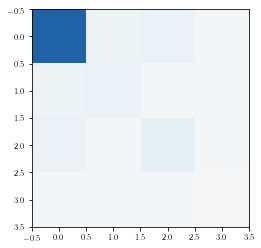

Assignment fidelity for ideal basis state 1: 0.8664768063673203


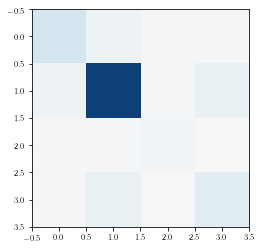

Assignment fidelity for ideal basis state 2: 0.5261238593241538


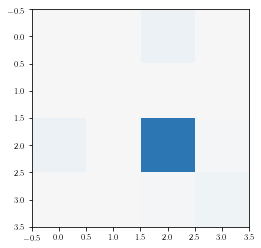

Assignment fidelity for ideal basis state 3: 0.707320457631831


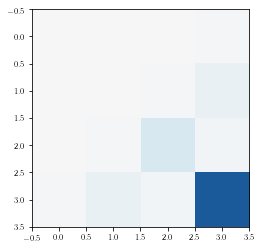

In [19]:
for i in range(4):
    print("Assignment fidelity for ideal basis state %i:"%i, np.abs(E_opt.reshape(4,4,4)[i,i,i])**2)
    plt.imshow(np.abs(E_opt.reshape(4,4,4)[i,:,:]), vmin = -1, vmax = 1)
    plt.show()